# PUI2016 HW5 - jp4772
## Assignment 1

## Instructions

>Test whether a gaussian model N($\mu$, $\sigma$) for the age distribution of citibike drivers is a sensible model, or if you can find a better fit with another distribution.

>Use 2 tests: KS, AD, KL, chisq (even though we have not talked about it in detail yet) to do this.

>Test at the Normal and a least one other distributions (e.g. Poisson, or Binomial, or Chisq, Lognormal.......)

>No skeleton: you are on your own!

>Extra credit: Divide your sample geographically: by Borrow + split Manhattan in an Uptown and a Downtown sample (use your discretion to do so, but ZIP code is a good idea) and see if you notice any differences in how the age distribution can be modeled.

>GRADING:

>Your notebook must:

>- state the $H_0$ correcty
- generate the distributions correctly.
- use the test correctly
- make conclusions about the rejection of the Null
- each plot must have a caption which describes the plot in terms of Central Limit Theorem

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn

import os

%matplotlib inline

In [2]:
if os.getenv("PUIDATA"):
    data_path = os.getenv("PUIDATA")
else:
    os.system('mkdir data')
    data_path = "./data"
    
# Download trip data for 6 months from Jan 2016 to June 2016. At the time of this writing (Oct 2, 2016), 
# these are the six latest months available.

dates = ['201601', '201602', '201603', '201604', '201605', '201606']
data_files = [date + "-citibike-tripdata.zip" for date in dates]

In [ ]:
# Download files
for f in data_files:
    os.system("curl -o " + data_path + "/" + f + " https://s3.amazonaws.com/tripdata/" + f)

In [3]:
# Load data files into a giant dataframe
df = pd.concat([pd.read_csv(data_path + "/" + file, header=0) for file in data_files])

# Reset index as the concatenation of several files runs havoc
df.reset_index(drop=True, inplace=True)

In [4]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,923,1/1/2016 00:00:41,1/1/2016 00:16:04,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22285,Subscriber,1958.0,1
1,379,1/1/2016 00:00:45,1/1/2016 00:07:04,476,E 31 St & 3 Ave,40.743943,-73.979661,498,Broadway & W 32 St,40.748549,-73.988084,17827,Subscriber,1969.0,1
2,589,1/1/2016 00:00:48,1/1/2016 00:10:37,489,10 Ave & W 28 St,40.750664,-74.001768,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,21997,Subscriber,1982.0,2
3,889,1/1/2016 00:01:06,1/1/2016 00:15:56,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22794,Subscriber,1961.0,2
4,1480,1/1/2016 00:01:12,1/1/2016 00:25:52,2006,Central Park S & 6 Ave,40.765909,-73.976342,2006,Central Park S & 6 Ave,40.765909,-73.976342,14562,Subscriber,1952.0,1


In [5]:
# Drop all rows where we do not have a birth year
df.dropna(inplace=True, subset=['birth year'])

In [6]:
# Generate age column
df['age'] = 2016 - df['birth year']

In [7]:
len(df[df['age'] > 86])

2444

In [8]:
# Over 2400 rides by riders over 86 feels much too high and a data issue.
# Only use data for riders under 86. 
df = df[df['age'] < 86]

In [9]:
# Drop unneeded columns
df.drop(['tripduration',
         'starttime', 
         'stoptime', 
         'start station id', 
         'start station name', 
         'start station latitude',
         'start station longitude',
         'end station id', 
         'end station name', 
         'end station latitude',
         'end station longitude',
         'bikeid',
         'usertype'], axis=1, inplace=True)

In [10]:
pd.set_option('display.float_format', '{:.8g}'.format)
df.describe()

,birth year,gender,age
count,5023948,5023948,5023948
mean,1977.1354,1.2322902,38.864645
std,11.571701,0.42761181,11.571701
min,1931,0,16
25%,1969,1,30
50%,1980,1,36
75%,1986,1,47
max,2000,2,85


In [11]:
# Generate dataframe for 
dfAge = pd.DataFrame(
    data=df.groupby(df.age).count().gender.values,
    index=df.groupby(df.age).count().index.astype("int64"),
    columns=["count"]
)

In [12]:
dfAge.describe()

,count
count,70
mean,71770.686
std,66972.235
min,1
25%,7210.25
50%,59035
75%,114673.25
max,208572


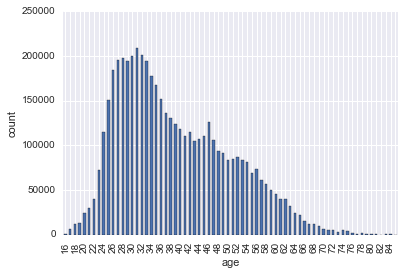

In [13]:
bar = dfAge[dfAge.index < 86].plot(kind="bar", legend=False)
bar.set_ylabel("count")

# Display x-label every other line
for label in bar.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
    
bar.set_xlabel('age')

### Figure 1: Distribution of the count per age of Citibike riders from Jan 2016 to Jun 2016

## Testing

We are trying to know if a normal or poisson distribution would be a good fit for the distribution of Citibike riders for the months of January to June 2016. We'll be using two tests to see if this is the case: a 2-sample KS test and a Pearson's R test. 

We'll write out a generic Null hypothesis applicable to both distributions and the two tests. It can be read as follows:

The distributions of the ages of Citibike riders between January and June 2016 *is equivalent within $\alpha = 0.5$* to the comparison distribution (normal or poisson).

Written as a formula:

$$
H_0 : \mu_{citibike} \simeq \mu_{comparison}
$$

## Normal Distribution

In [14]:
# Generate a normal distribution with the same mean and standard deviation of our citibike dataset
normal = np.random.normal(39, 11.5, 5023948)

In [19]:
# Make all numbers integers (like real ages)
nm = normal.astype("int64")

In [20]:
# Count the unique number of ages
np_array = np.unique(nm, return_counts=True)

In [17]:
dfNormal = pd.DataFrame(
    data=np_array[1],
    index=np_array[0],
    columns=["count"]
)

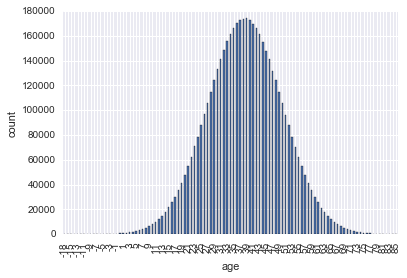

In [18]:
bar = dfNormal[dfNormal.index < 86].plot(kind="bar", legend=False)
bar.set_ylabel("count")

# Display x-label every other line
for label in bar.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
    
bar.set_xlabel('age')

### Figure 2: Generated normal distribution of rider ages with mean of 39 and std dev of 12.

#### KS Test

In [29]:
scipy.stats.ks_2samp(dfAge["count"], dfNormal["count"])

Ks_2sampResult(statistic=0.27980295566502461, pvalue=0.0016154608493663099)

With such a small KS-statistic, it appears we **cannot** reject the Null hypothesis. As the 2-sample KS test documentation reads:

> If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

#### Pearson's R

In [309]:
scipy.stats.pearsonr(dfAge["count"], dfNormal[(dfNormal.index >= 16) & (dfNormal.index < 86)]["count"])

(0.86651262395969986, 3.3442347572660016e-22)

A Pearson's R tests for correlation between two sets of data. The closer to 1 (being a perfect correlation), the more correlated the datasets. A correlation of 0.866 is quite high. Thus, once again, we **cannot** reject the Null hypothesis.

## Poisson Distribution

In [21]:
# Generate a poisson distribution with the same mean as our sample
poisson = np.random.poisson(39, 5024334)

In [22]:
ps = poisson.astype("int64")

In [23]:
ps_array = np.unique(poisson, return_counts=True)

In [24]:
dfPoisson = pd.DataFrame(
    data=ps_array[1],
    index=ps_array[0],
    columns=["count"]
)

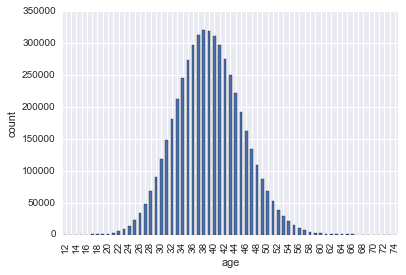

In [25]:
bar = dfPoisson[dfPoisson.index < 80].plot(kind="bar", legend=False)
bar.set_ylabel("count")

# Display x-label every other line
for label in bar.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
    
bar.set_xlabel('age')

### Figure 3: Generated poisson distribution of rider ages with age of 29. 

#### KS Test

In [30]:
scipy.stats.ks_2samp(dfAge["count"], dfPoisson["count"])

Ks_2sampResult(statistic=0.24126984126984125, pvalue=0.03487672571627716)

Like the Normal distribution above, the ks statistic in this case is even lower, meaning we once again **cannot** reject the Null hypothesis.

#### Pearson's R

In [28]:
scipy.stats.pearsonr(dfAge[dfAge.index < 75]["count"], dfPoisson[dfPoisson.index >= 16]["count"])

(0.62829440342852838, 9.9619360770377361e-08)

Though the correlation here is less strong then that of the Normal distribution, it is still not low enough for us to consider the two uncorrelated. Once again, we **reject** the Null hypothesis.